In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
import astropy.units as u

import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload 2

In [37]:
rootdir = Path("/Volumes/LaCie 8TB/wfsdat")
# use find to make this csv list
with open(rootdir / "reanalyze_csvs.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(rootdir / csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames, sort=True)

g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,6308,1,binospec,6308
f5,1169,1,f5,1169
mmirs,1166,1,mmirs,1166
newf9,385,1,newf9,385


In [38]:
data.tail()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,seeing,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen
4,1.03,327.73,-0.000,0.048,6.7,75.97,30.0,manual_wfs_0004.fits,0.76,14467.70,...,0.532146,258.87,102.63,2019-05-09T06:47:53,370.16,2330.41,257.667092,f5,231.917863,245.008014
5,1.05,313.97,-0.000,0.320,6.4,71.98,30.0,manual_wfs_0005.fits,-5.28,14461.64,...,0.500915,268.20,107.09,2019-05-09T08:04:37,317.70,2435.48,291.395164,f5,233.078974,254.002908
6,1.01,186.87,-0.000,3.223,6.2,81.10,30.0,manual_wfs_0006.fits,-5.12,14477.30,...,0.531363,227.64,96.78,2019-05-09T09:21:09,443.48,2006.87,385.398088,f5,236.075276,253.753760
7,1.01,188.80,-0.020,0.709,6.2,81.06,30.0,manual_wfs_0007.fits,-0.00,14518.93,...,0.537824,227.57,96.82,2019-05-09T09:22:28,442.77,2007.10,133.124015,f5,239.032211,251.681788
8,NaN,NaN,-0.936,0.000,NaN,NaN,NaN,tmp.fits,-0.00,NaN,...,0.541045,NaN,NaN,2019-05-09T20:31:21,NaN,NaN,133.102449,f5,239.048142,251.581741


In [39]:
data['comaerr'] = np.hypot(data['cc_x_err'], data['cc_y_err'])

In [40]:
fixed = data[(np.abs(data['focerr']) < 20.) & (data['comaerr'] < 5.) & (data['el'] != np.nan)]
fixed = fixed.dropna()

# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

In [43]:
f9 = fixed[fixed['wfs'] == 'newf9']
f5 = fixed[fixed['wfs'] == 'f5']
mmirs = fixed[fixed['wfs'] == 'mmirs']
bino = fixed[fixed['wfs'] == 'binospec']

In [44]:
f5.tail()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr
ut,,,,,,,,,,,,,,,,,,,,,
2019-05-09 04:47:49,1.03,249.48,1.007,-0.000,6.1,75.37,30.0,manual_wfs_0002.fits,6.44,14371.70,...,247.07,103.28,2019-05-09T04:47:49,362.84,2219.73,433.681871,f5,233.001664,255.564129,1.007000
2019-05-09 06:47:53,1.03,327.73,-0.000,0.048,6.7,75.97,30.0,manual_wfs_0004.fits,0.76,14467.70,...,258.87,102.63,2019-05-09T06:47:53,370.16,2330.41,257.667092,f5,231.917863,245.008014,0.048000
2019-05-09 08:04:37,1.05,313.97,-0.000,0.320,6.4,71.98,30.0,manual_wfs_0005.fits,-5.28,14461.64,...,268.20,107.09,2019-05-09T08:04:37,317.70,2435.48,291.395164,f5,233.078974,254.002908,0.320000
2019-05-09 09:21:09,1.01,186.87,-0.000,3.223,6.2,81.10,30.0,manual_wfs_0006.fits,-5.12,14477.30,...,227.64,96.78,2019-05-09T09:21:09,443.48,2006.87,385.398088,f5,236.075276,253.753760,3.223000
2019-05-09 09:22:28,1.01,188.80,-0.020,0.709,6.2,81.06,30.0,manual_wfs_0007.fits,-0.00,14518.93,...,227.57,96.82,2019-05-09T09:22:28,442.77,2007.10,133.124015,f5,239.032211,251.681788,0.709282


<IPython.core.display.Javascript object>


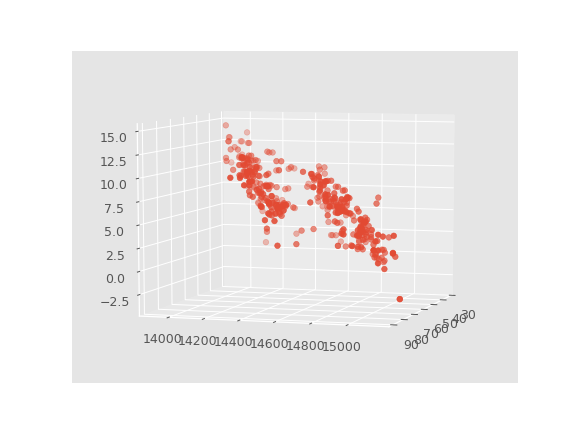

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(f5['el'], f5['focus'], f5['osst'])
plt.show()

<IPython.core.display.Javascript object>


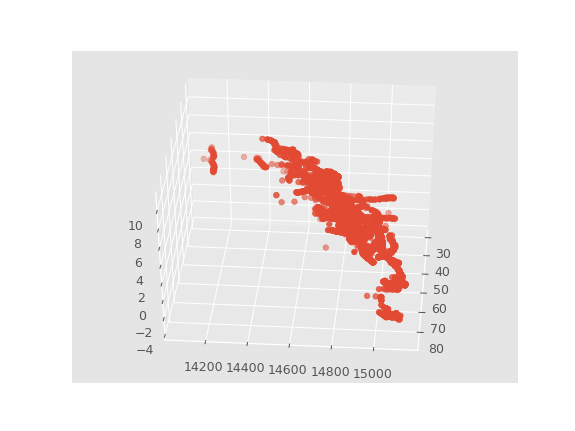

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(bino['el'], bino['focus'], bino['osst'])
plt.show()

In [45]:
fixed.to_csv("../test_data/2019_wfs.csv")